# References

Project Link: https://learn.co/tracks/module-4-data-science-career-2-1/final-project/final-project/module-4-final-project

Notebook Reference: https://www.kaggle.com/michawilkosz/twitter-sentiment-analysis-using-tensorflow


**Data Source**: https://data.world/crowdflower/brands-and-product-emotions

Summary:

Contributors evaluated tweets about multiple brands and products. 

The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. 

If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. 

Added: August 30, 2013 by Kent Cavender-Bares

Data Rows: 9093



# Import

In [1]:
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#sklearn
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras import regularizers
#keras
import tensorflow as tf
# resampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import re
import os
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")

import pickle


# import sys
# additional_paths = ['/content/drive/MyDrive/Flatiron/Module4']
# for path in additional_paths:
#   if path not in sys.path:
#     sys.path.append(path)

[nltk_data] Downloading package stopwords to /home/xkluo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Seems there's no GPU to be used.

# EDA

In [3]:
data_raw = pd.read_csv('./raw_data/judge-1377884607_tweet_product_company.csv',encoding= 'unicode_escape')

In [4]:
display(data_raw.head())
display(data_raw.tail())

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


<AxesSubplot:>

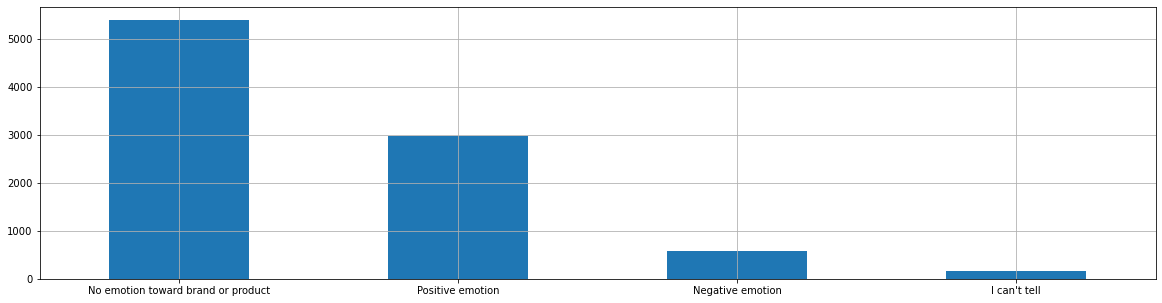

In [5]:
pd.value_counts(data_raw['is_there_an_emotion_directed_at_a_brand_or_product']).plot.bar(figsize=(20,5),grid=True,rot=0)

<AxesSubplot:>

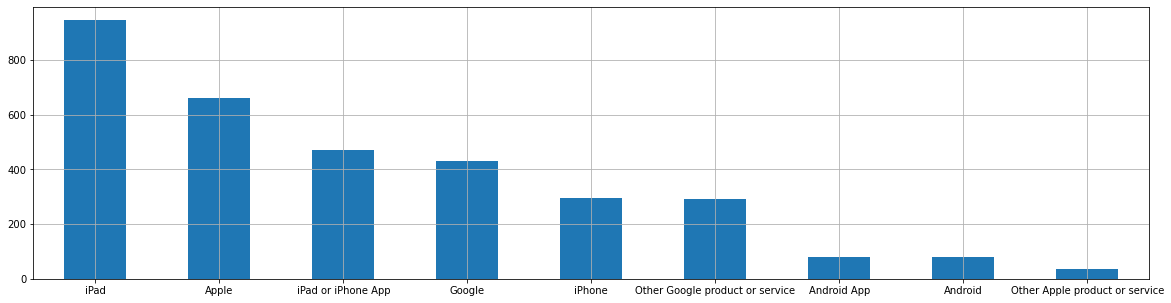

In [6]:
pd.value_counts(data_raw['emotion_in_tweet_is_directed_at']).plot.bar(figsize=(20,5),grid=True,rot=0)

In [7]:
data_raw.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [8]:
data_renamed = data_raw.rename(columns={'tweet_text': 'content', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'target'})
data = data_renamed
data.head(1)

,content,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion


In [9]:
data = data_renamed
missing_data = data.isna().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
product,5802,63.810000
content,1,0.010000
target,0,0.000000


In [10]:

data_dropna = data.dropna()
data = data_dropna
data['length'] = data.content.str.split().apply(len)
missing_data = data.isna().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
content,0,0.000000
product,0,0.000000
target,0,0.000000
length,0,0.000000


In [11]:
pd.set_option('display.max_colwidth', -1)
data[data['target']=='Positive emotion']['content'].head()

1    @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
2    @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                            
4    @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)        
7    #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan 
8    Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB          
Name: content, dtype: object

In [12]:
pd.set_option('display.max_colwidth', -1)
data[data['target']=='Negative emotion']['content'].head()

0     .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW. 
3     @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                              
17    I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone
38    @mention  - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW         
67    attending @mention iPad design headaches #sxsw {link}                                                                           
Name: content, dtype: object

In [13]:
pd.set_option('display.max_colwidth', -1)
data[data['target']=='No emotion toward brand or product']['content'].head()

63     #Smile RT @mention I think Apple's &quot;pop-up store&quot; in Austin would be a lot more interesting if it actually, you know... popped up #sxsw
265    The #SXSW Apple &quot;pop-up&quot; store was nuts. Was still packed at 11:30. {link}                                                             
317    I arrived at #sxsw and my @mention issue hasn't been resolved. Dying to use the iPhone app but cant login. RT@mention @mention we're on it       
558    haha. the google &quot;Party like it's 1986&quot; Party {link} #SXSW                                                                             
588    Diller on Google TV: &quot;The first product wasn't good. It wasn't a consumer product, basically.&quot; #sxsw #diller                           
Name: content, dtype: object

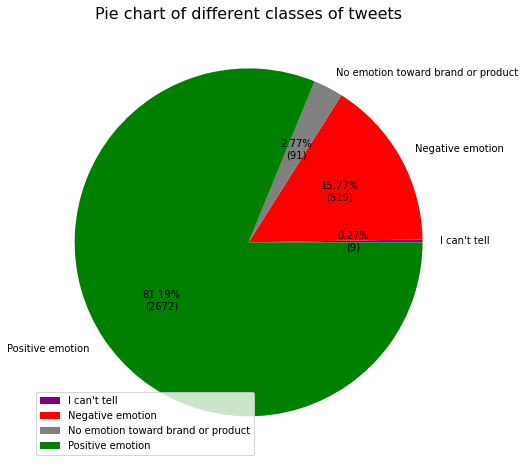

In [24]:
fig = plt.figure(figsize=(8,8))
targets = data.groupby('target').size()
# targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['purple','red','grey','green'])
targets.plot(kind='pie', subplots=True, figsize=(10, 8), 
        autopct = lambda val: f"{val:.2f}%\n({val/100*data['target'].value_counts().sum():.0f})", 
        colors=['purple','red','grey','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

In [15]:
data['target'].value_counts().sum()

3291

In [60]:
data['target'].value_counts()

Positive emotion                      2672
Negative emotion                      519 
No emotion toward brand or product    91  
I can't tell                          9   
Name: target, dtype: int64

This data is very unbalanced: Need resampling later

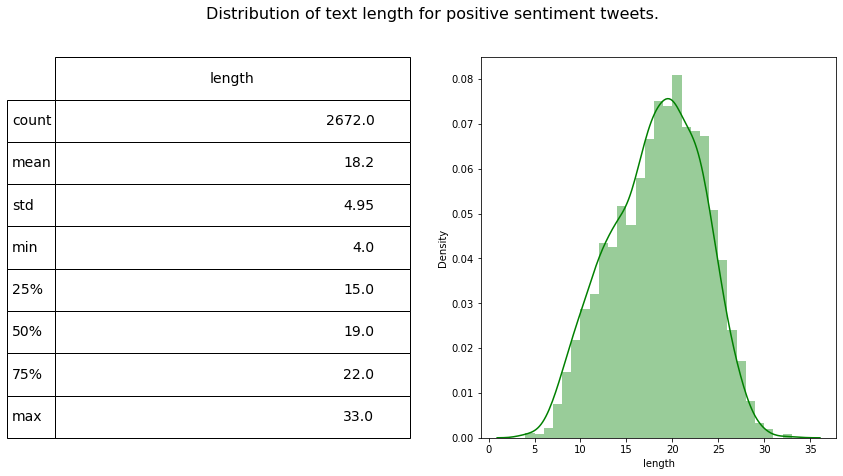

In [61]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Positive emotion']['length'], ax=ax1,color='green')
describe = data.length[data.target=='Positive emotion'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

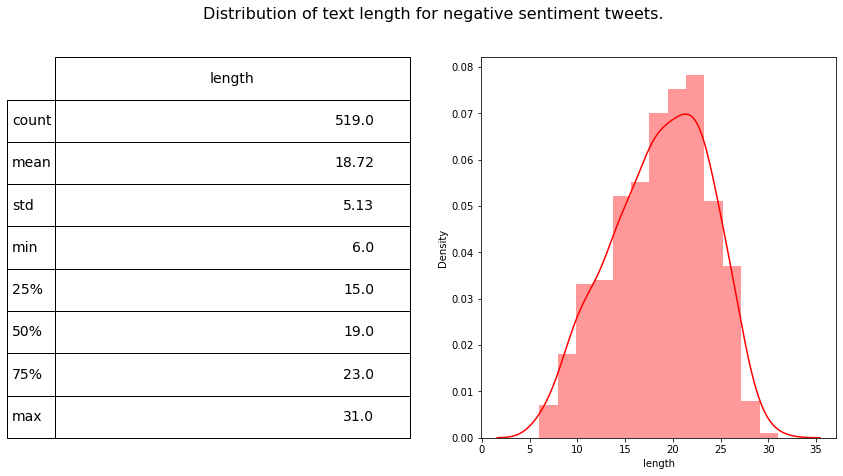

In [62]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Negative emotion']['length'], ax=ax1,color='red')
describe = data.length[data.target=='Negative emotion'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

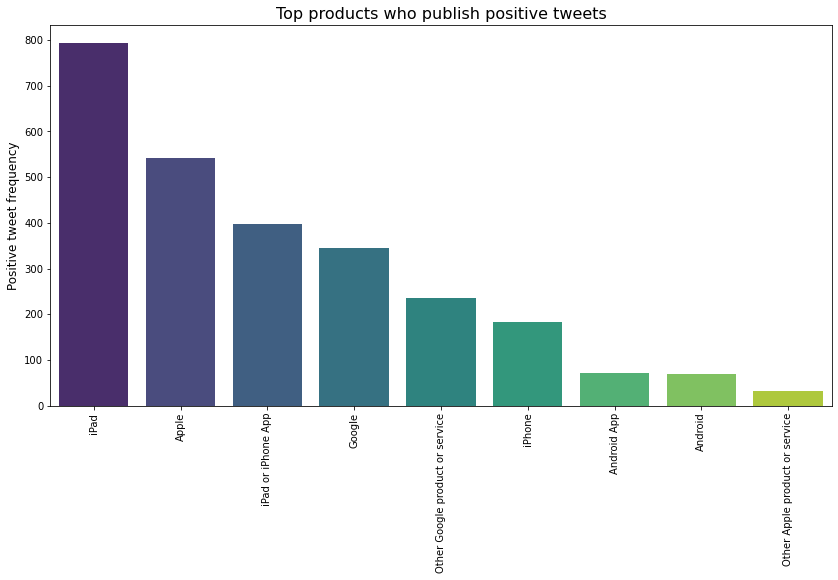

In [63]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Positive emotion']['product'].value_counts().index, \
                           y=data[data['target']=='Positive emotion']['product'].value_counts(),palette='viridis')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Positive tweet frequency',fontsize=12)
plt.title('Top products who publish positive tweets',fontsize=16)
plt.show()

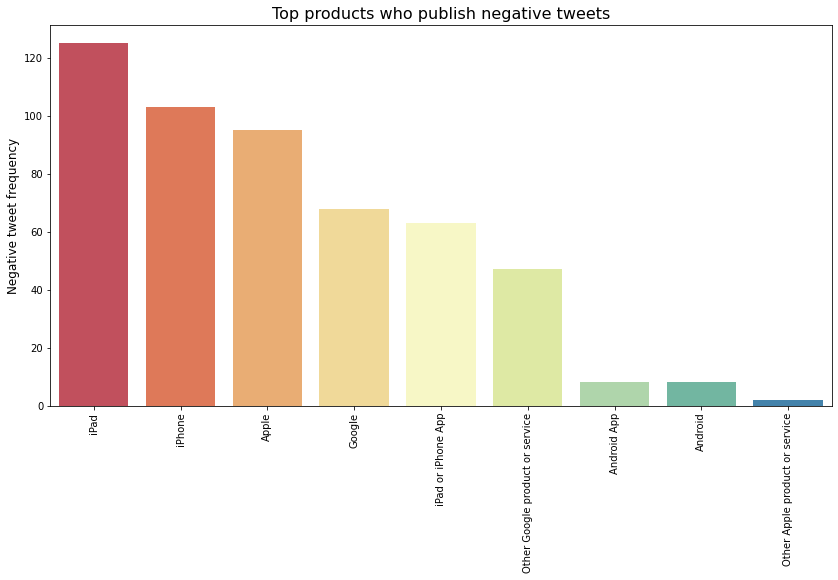

In [64]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Negative emotion']['product'].value_counts().index, \
                           y=data[data['target']=='Negative emotion']['product'].value_counts(),palette='Spectral')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Negative tweet frequency',fontsize=12)
plt.title('Top products who publish negative tweets',fontsize=16)
plt.show()

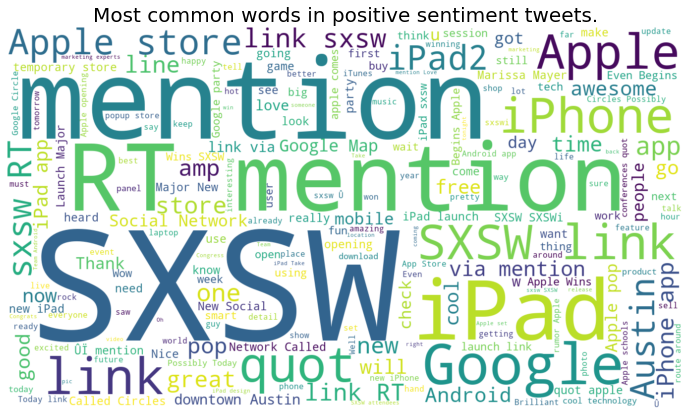

In [65]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Positive emotion'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in positive sentiment tweets.',fontsize=20)
plt.show()

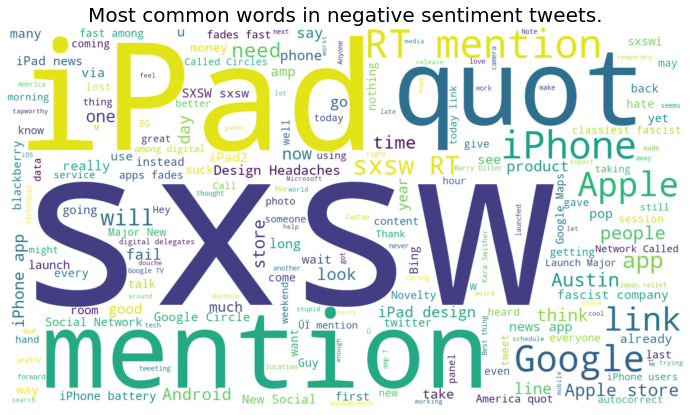

In [66]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Negative emotion'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

The above two plots aren't so different.

# Model Building

Encoding the target:

In [67]:
data_drop = data_dropna.copy()
data = data_drop
data.drop(['product','length'], axis=1, inplace=True)
data.target = data.target.replace({'Positive emotion': 1, 'Negative emotion': 0, 'No emotion toward brand or product':0, "I can't tell":0})
data.head()

,content,target
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",1
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,1
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",1


In [68]:
english_stopwords = stopwords.words('english')
#base of english stopwords
stemmer = SnowballStemmer('english')
#stemming algorithm
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
# regex = " "
#regex for mentions and links in tweets
def preprocess(content, stem=False):
  content = re.sub(regex, ' ', str(content).lower()).strip()
  # content = str(content).lower().strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
      # tokens.append(token)
  return " ".join(tokens)
data = data_drop.copy()
data.content = data.content.apply(lambda x: preprocess(x))
data.head()

,content,target
0,wesley83 3g iphon 3 hrs tweet rise austin dead need upgrad plugin station sxsw,0
1,know fludapp awesom ipad iphon app like appreci design also give free ts sxsw,1
2,wait ipad 2 also sale sxsw,1
3,hope year festiv crashi year iphon app sxsw,0
4,great stuff fri sxsw marissa mayer googl tim reilli tech book confer amp matt mullenweg wordpress,1


Split sentences:

In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.content)  
vocab_size = len(tokenizer.word_index) + 1 
max_length = np.max(data.content.apply(len))

Load pre-made word vector:

In [70]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('./glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

Turn input into word vector sequence of the same size:

In [71]:
sequences = tokenizer.texts_to_sequences(data.content) 
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = data.target

Resampling to the category with least data:

In [72]:
# define resampling strategy
resample = RandomUnderSampler(sampling_strategy='auto')
# fit and apply the transform
X_resample, y_resample = resample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_resample))

Counter({0: 619, 1: 619})


Split train and test sets

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, random_state=42)
# y_train = y_train.astype('int32')
# y_test = y_test.astype('int32')
print('Train dataset shape: {}'.format(X_train.shape))
print(Counter(y_train))
print('Test dataset shape: {}'.format(X_test.shape))
print(Counter(y_test))

Train dataset shape: (928, 129)
Counter({1: 474, 0: 454})
Test dataset shape: (310, 129)
Counter({0: 165, 1: 145})


In [74]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)
num_epochs = 50
batch_size = 1000

In [75]:
def display_auc_loss(model, history):
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred>0.5, 1, 0)
    print(classification_report(y_test, y_pred))
    print('Absolute:')
    print(sklearn.metrics.confusion_matrix(y_test, y_pred, normalize=None))
    print('True:')
    print(sklearn.metrics.confusion_matrix(y_test, y_pred, normalize='true'))
    print('Predicted:')
    print(sklearn.metrics.confusion_matrix(y_test, y_pred, normalize='pred'))

    #History for auc
    plt.figure(figsize=(10,5))
    plt.suptitle('Model AUC and Loss')
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model auc')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['Train auc', 'Test auc'], loc='lower right')
    plt.show()
    # History for loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Test loss'], loc='upper right')
    plt.show()

In [76]:
models = {}
histories = {}

# Version 1


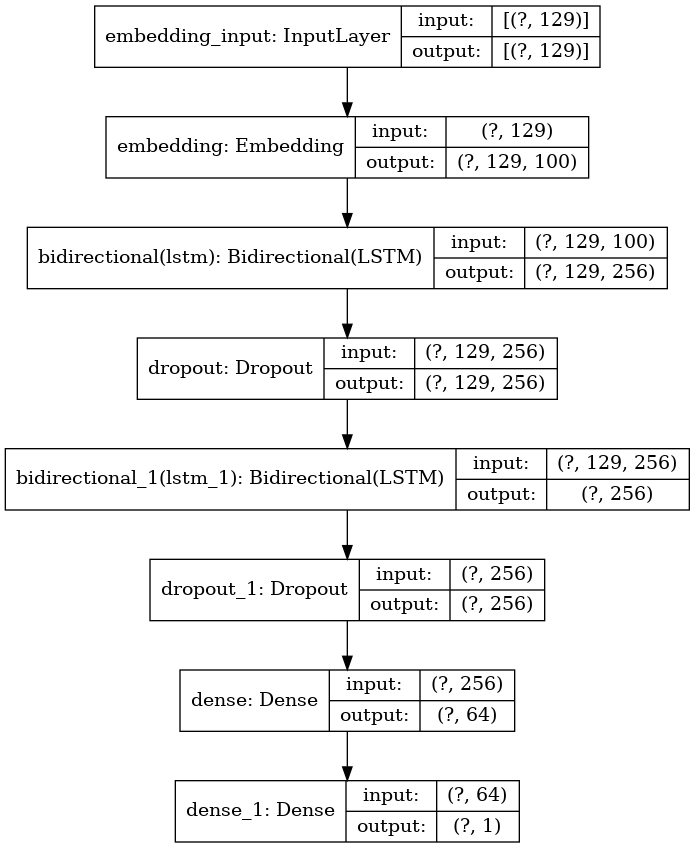

In [77]:
tf.keras.backend.clear_session()
models[1] = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

tf.keras.utils.plot_model(models[1], show_shapes=True)

In [78]:
%%time
# categorical_crossentropy
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
models[1].compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])
histories[1] = models[1].fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
1/1 - 3s - loss: 0.6954 - auc: 0.4904 - val_loss: 0.6935 - val_auc: 0.6404
Epoch 2/50
1/1 - 1s - loss: 0.6887 - auc: 0.5992 - val_loss: 0.6957 - val_auc: 0.6626
Epoch 3/50
1/1 - 1s - loss: 0.6868 - auc: 0.6326 - val_loss: 0.6884 - val_auc: 0.6823
Epoch 4/50
1/1 - 1s - loss: 0.6791 - auc: 0.6834 - val_loss: 0.6790 - val_auc: 0.6876
Epoch 5/50
1/1 - 1s - loss: 0.6739 - auc: 0.6981 - val_loss: 0.6716 - val_auc: 0.6826
Epoch 6/50
1/1 - 1s - loss: 0.6666 - auc: 0.7169 - val_loss: 0.6637 - val_auc: 0.6925
Epoch 7/50
1/1 - 1s - loss: 0.6603 - auc: 0.7025 - val_loss: 0.6572 - val_auc: 0.7002
Epoch 8/50
1/1 - 1s - loss: 0.6482 - auc: 0.7212 - val_loss: 0.6431 - val_auc: 0.6979
Epoch 9/50
1/1 - 1s - loss: 0.6308 - auc: 0.7312 - val_loss: 0.6338 - val_auc: 0.6938
Epoch 10/50
1/1 - 1s - loss: 0.6124 - auc: 0.7458 - val_loss: 0.6310 - val_auc: 0.7099
Epoch 11/50
1/1 - 1s - loss: 0.5985 - auc: 0.7529 - val_loss: 0.6227 - val_auc: 0.7107
Epoch 12/50
1/1 - 1s - loss: 0.5825 - auc: 0.7609 - 

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       165
           1       0.71      0.57      0.63       145

    accuracy                           0.69       310
   macro avg       0.69      0.68      0.68       310
weighted avg       0.69      0.69      0.69       310

Absolute:
[[131  34]
 [ 62  83]]
True:
[[0.79393939 0.20606061]
 [0.42758621 0.57241379]]
Predicted:
[[0.67875648 0.29059829]
 [0.32124352 0.70940171]]


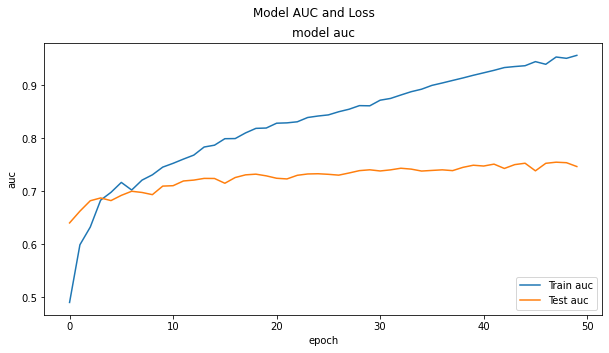

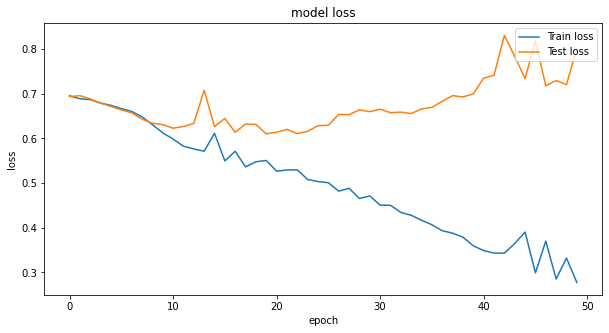

In [79]:
display_auc_loss(models[1], histories[1])

# Version 2

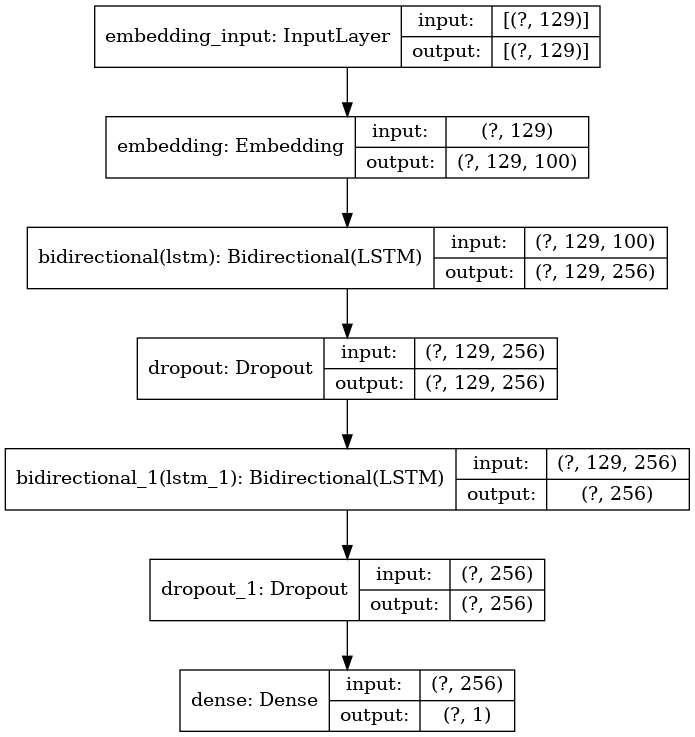

In [80]:
tf.keras.backend.clear_session()
models[2] = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

tf.keras.utils.plot_model(models[2], show_shapes=True)

In [81]:
%%time
# categorical_crossentropy
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
models[2].compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])
histories[2] = models[2].fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
1/1 - 2s - loss: 0.6915 - auc: 0.5372 - val_loss: 0.6943 - val_auc: 0.6434
Epoch 2/50
1/1 - 1s - loss: 0.6866 - auc: 0.6192 - val_loss: 0.6863 - val_auc: 0.6742
Epoch 3/50
1/1 - 1s - loss: 0.6799 - auc: 0.6758 - val_loss: 0.6787 - val_auc: 0.6629
Epoch 4/50
1/1 - 1s - loss: 0.6751 - auc: 0.6751 - val_loss: 0.6721 - val_auc: 0.6738
Epoch 5/50
1/1 - 1s - loss: 0.6642 - auc: 0.7067 - val_loss: 0.6662 - val_auc: 0.6877
Epoch 6/50
1/1 - 1s - loss: 0.6529 - auc: 0.7208 - val_loss: 0.6568 - val_auc: 0.6931
Epoch 7/50
1/1 - 1s - loss: 0.6365 - auc: 0.7395 - val_loss: 0.6412 - val_auc: 0.6883
Epoch 8/50
1/1 - 1s - loss: 0.6204 - auc: 0.7408 - val_loss: 0.6310 - val_auc: 0.6964
Epoch 9/50
1/1 - 1s - loss: 0.6008 - auc: 0.7500 - val_loss: 0.6422 - val_auc: 0.7046
Epoch 10/50
1/1 - 1s - loss: 0.5955 - auc: 0.7597 - val_loss: 0.6486 - val_auc: 0.6982
Epoch 11/50
1/1 - 1s - loss: 0.6015 - auc: 0.7551 - val_loss: 0.6336 - val_auc: 0.7108
Epoch 12/50
1/1 - 1s - loss: 0.5711 - auc: 0.7757 - 

              precision    recall  f1-score   support

           0       0.66      0.81      0.72       165
           1       0.70      0.52      0.60       145

    accuracy                           0.67       310
   macro avg       0.68      0.66      0.66       310
weighted avg       0.68      0.67      0.66       310

Absolute:
[[133  32]
 [ 70  75]]
True:
[[0.80606061 0.19393939]
 [0.48275862 0.51724138]]
Predicted:
[[0.65517241 0.29906542]
 [0.34482759 0.70093458]]


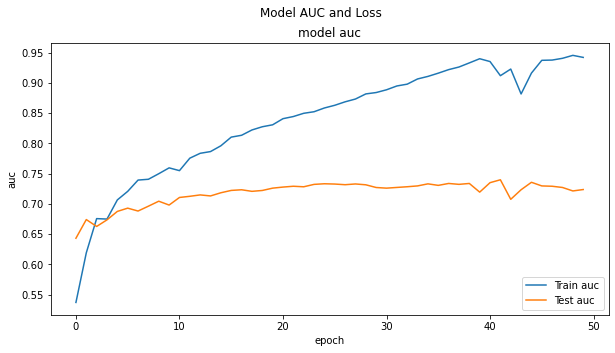

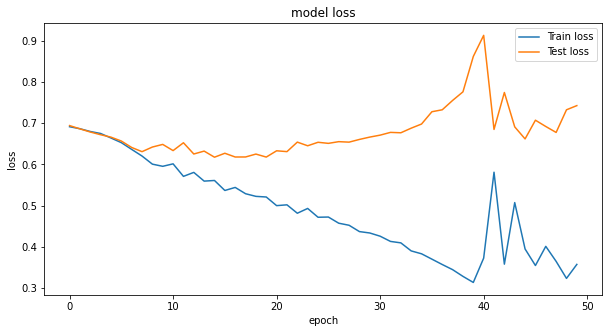

In [82]:
display_auc_loss(models[2], histories[2])

# Version 3

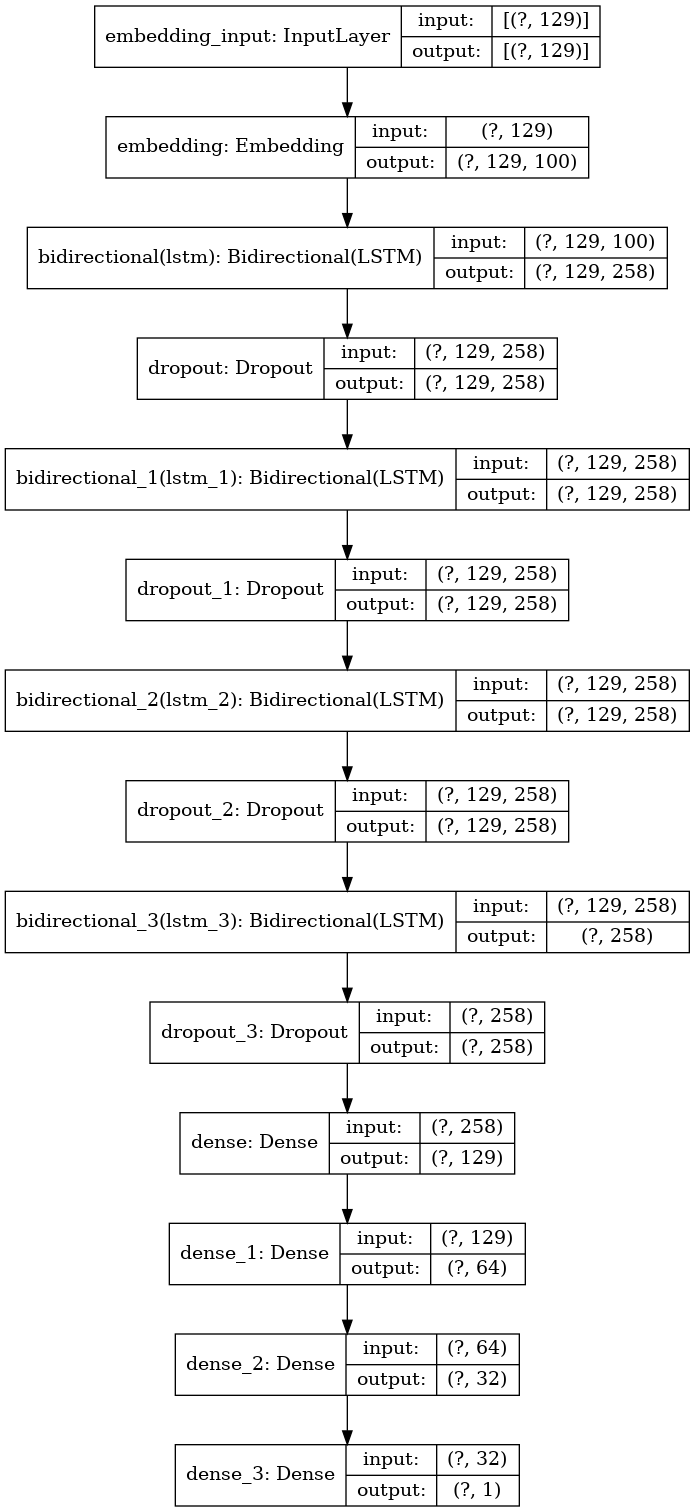

In [83]:
tf.keras.backend.clear_session()
models[3] = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(max_length)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(int(max_length), activation='relu'),
        tf.keras.layers.Dense(int(max_length/2), activation='relu'),
        tf.keras.layers.Dense(int(max_length/4), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

tf.keras.utils.plot_model(models[3], show_shapes=True)

In [84]:
%%time
# categorical_crossentropy
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
models[3].compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])
histories[3] = models[3].fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
1/1 - 4s - loss: 0.6938 - auc: 0.4692 - val_loss: 0.6929 - val_auc: 0.4978
Epoch 2/50
1/1 - 2s - loss: 0.6932 - auc: 0.5103 - val_loss: 0.6928 - val_auc: 0.5756
Epoch 3/50
1/1 - 2s - loss: 0.6927 - auc: 0.5204 - val_loss: 0.6917 - val_auc: 0.6192
Epoch 4/50
1/1 - 2s - loss: 0.6918 - auc: 0.5827 - val_loss: 0.6887 - val_auc: 0.6368
Epoch 5/50
1/1 - 2s - loss: 0.6905 - auc: 0.6051 - val_loss: 0.6846 - val_auc: 0.6702
Epoch 6/50
1/1 - 2s - loss: 0.6881 - auc: 0.6263 - val_loss: 0.6851 - val_auc: 0.6381
Epoch 7/50
1/1 - 2s - loss: 0.6852 - auc: 0.6408 - val_loss: 0.6745 - val_auc: 0.6768
Epoch 8/50
1/1 - 2s - loss: 0.6775 - auc: 0.6864 - val_loss: 0.6664 - val_auc: 0.6795
Epoch 9/50
1/1 - 2s - loss: 0.6702 - auc: 0.7091 - val_loss: 0.6681 - val_auc: 0.6641
Epoch 10/50
1/1 - 2s - loss: 0.6663 - auc: 0.6868 - val_loss: 0.6526 - val_auc: 0.6786
Epoch 11/50
1/1 - 2s - loss: 0.6467 - auc: 0.7104 - val_loss: 0.6773 - val_auc: 0.6802
Epoch 12/50
1/1 - 2s - loss: 0.6675 - auc: 0.7246 - 

              precision    recall  f1-score   support

           0       0.74      0.58      0.65       165
           1       0.61      0.77      0.68       145

    accuracy                           0.66       310
   macro avg       0.67      0.67      0.66       310
weighted avg       0.68      0.66      0.66       310

Absolute:
[[ 95  70]
 [ 34 111]]
True:
[[0.57575758 0.42424242]
 [0.23448276 0.76551724]]
Predicted:
[[0.73643411 0.38674033]
 [0.26356589 0.61325967]]


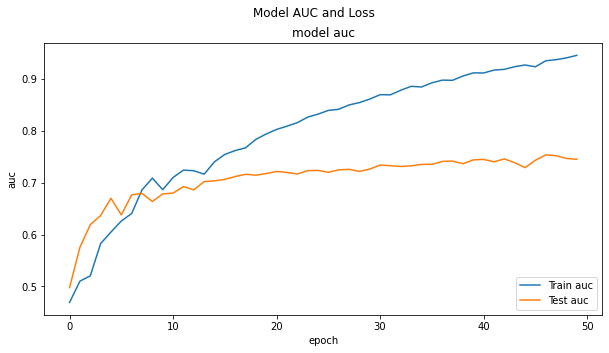

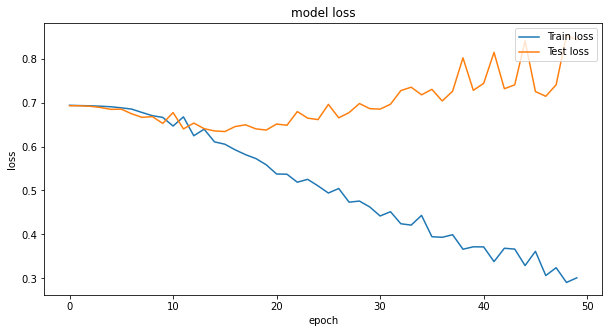

In [85]:
display_auc_loss(models[3], histories[3])

# Version 4

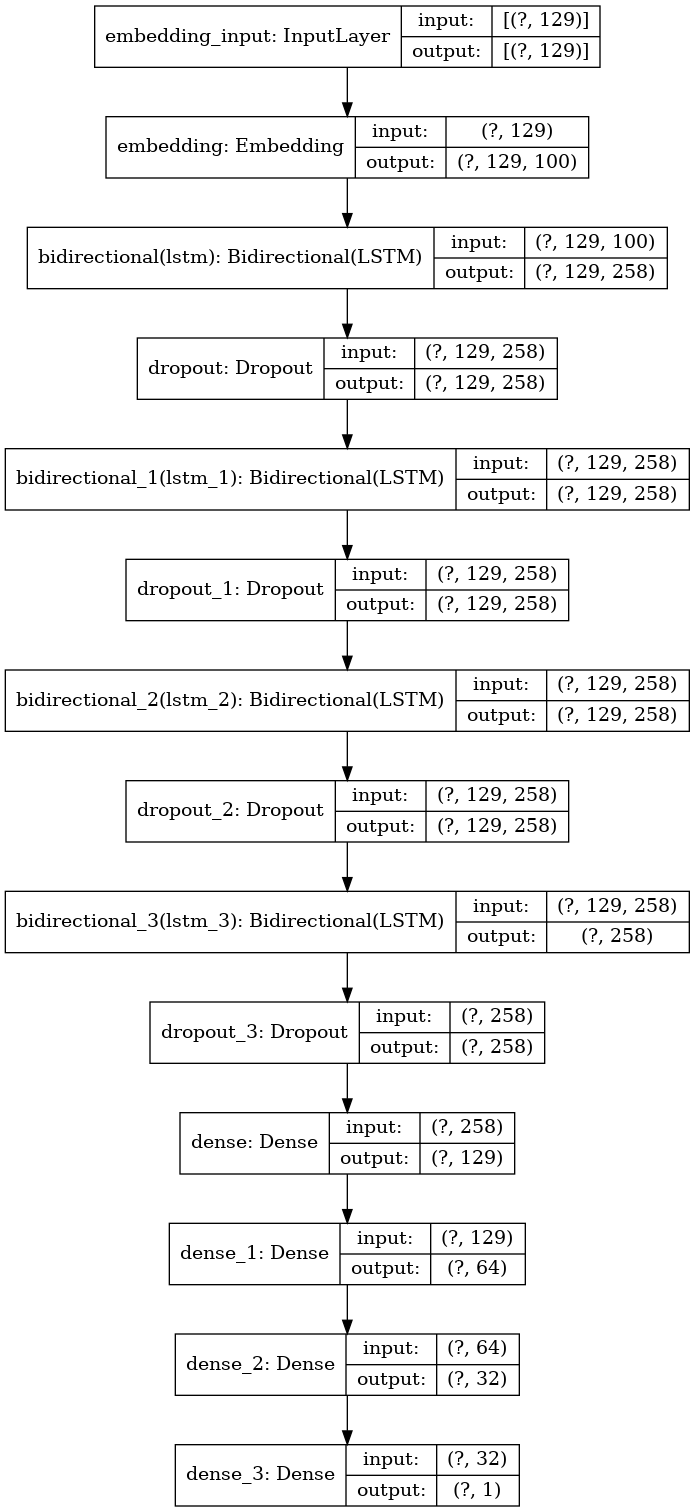

In [86]:
tf.keras.backend.clear_session()
models[4] = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(int(max_length), activation='relu'),
        tf.keras.layers.Dense(int(max_length/2), activation='relu'),
        tf.keras.layers.Dense(int(max_length/4), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

tf.keras.utils.plot_model(models[4], show_shapes=True)

In [87]:
%%time
# categorical_crossentropy
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
models[4].compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])
histories[4] = models[4].fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
1/1 - 4s - loss: 0.6927 - auc: 0.5408 - val_loss: 0.6930 - val_auc: 0.6045
Epoch 2/50
1/1 - 1s - loss: 0.6920 - auc: 0.5666 - val_loss: 0.6923 - val_auc: 0.6592
Epoch 3/50
1/1 - 1s - loss: 0.6904 - auc: 0.5981 - val_loss: 0.6874 - val_auc: 0.6788
Epoch 4/50
1/1 - 1s - loss: 0.6877 - auc: 0.6339 - val_loss: 0.6864 - val_auc: 0.6848
Epoch 5/50
1/1 - 1s - loss: 0.6827 - auc: 0.6721 - val_loss: 0.6713 - val_auc: 0.6950
Epoch 6/50
1/1 - 2s - loss: 0.6721 - auc: 0.6990 - val_loss: 0.6614 - val_auc: 0.6996
Epoch 7/50
1/1 - 2s - loss: 0.6539 - auc: 0.7308 - val_loss: 0.6507 - val_auc: 0.6817
Epoch 8/50
1/1 - 1s - loss: 0.6473 - auc: 0.7249 - val_loss: 0.6884 - val_auc: 0.6908
Epoch 9/50
1/1 - 1s - loss: 0.6643 - auc: 0.7050 - val_loss: 0.6448 - val_auc: 0.7080
Epoch 10/50
1/1 - 1s - loss: 0.6169 - auc: 0.7449 - val_loss: 0.6924 - val_auc: 0.6815
Epoch 11/50
1/1 - 1s - loss: 0.6769 - auc: 0.7205 - val_loss: 0.6198 - val_auc: 0.7137
Epoch 12/50
1/1 - 1s - loss: 0.5966 - auc: 0.7545 - 

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       165
           1       0.66      0.76      0.71       145

    accuracy                           0.70       310
   macro avg       0.71      0.71      0.70       310
weighted avg       0.71      0.70      0.70       310

Absolute:
[[108  57]
 [ 35 110]]
True:
[[0.65454545 0.34545455]
 [0.24137931 0.75862069]]
Predicted:
[[0.75524476 0.34131737]
 [0.24475524 0.65868263]]


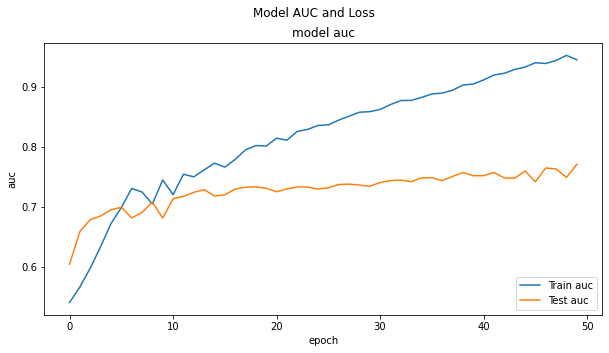

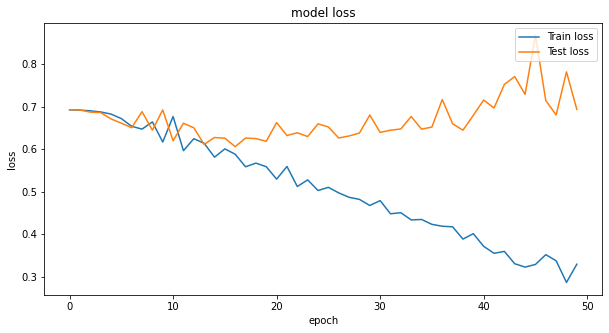

In [88]:
display_auc_loss(models[4], histories[4])

# Version 5

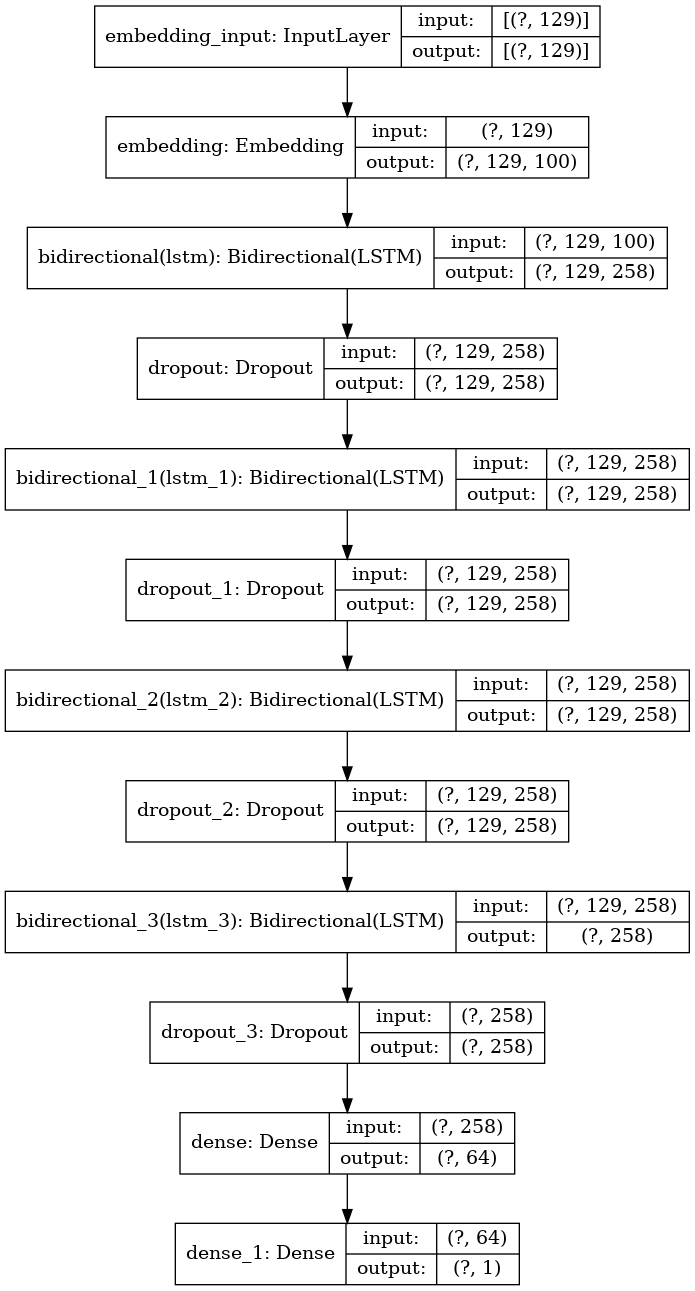

In [89]:
tf.keras.backend.clear_session()
models[5] = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length)),
        tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(int(max_length), activation='relu'),
        tf.keras.layers.Dense(int(max_length/2), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)),
        # tf.keras.layers.Dense(int(max_length/4), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)),
    ])

tf.keras.utils.plot_model(models[5], show_shapes=True)

In [90]:
%%time
# categorical_crossentropy
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
models[5].compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])
histories[5] = models[5].fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
1/1 - 3s - loss: 0.7153 - auc: 0.4899 - val_loss: 0.7150 - val_auc: 0.6324
Epoch 2/50
1/1 - 1s - loss: 0.7123 - auc: 0.5620 - val_loss: 0.7123 - val_auc: 0.6616
Epoch 3/50
1/1 - 1s - loss: 0.7071 - auc: 0.6353 - val_loss: 0.7088 - val_auc: 0.6734
Epoch 4/50
1/1 - 1s - loss: 0.7041 - auc: 0.6350 - val_loss: 0.6953 - val_auc: 0.6823
Epoch 5/50
1/1 - 1s - loss: 0.6921 - auc: 0.6748 - val_loss: 0.6782 - val_auc: 0.6778
Epoch 6/50
1/1 - 1s - loss: 0.6741 - auc: 0.6982 - val_loss: 0.6964 - val_auc: 0.6922
Epoch 7/50
1/1 - 1s - loss: 0.6746 - auc: 0.7021 - val_loss: 0.6812 - val_auc: 0.6529
Epoch 8/50
1/1 - 1s - loss: 0.6676 - auc: 0.7012 - val_loss: 0.6570 - val_auc: 0.6874
Epoch 9/50
1/1 - 1s - loss: 0.6365 - auc: 0.7173 - val_loss: 0.6909 - val_auc: 0.6997
Epoch 10/50
1/1 - 1s - loss: 0.6525 - auc: 0.7350 - val_loss: 0.6505 - val_auc: 0.7041
Epoch 11/50
1/1 - 1s - loss: 0.6174 - auc: 0.7507 - val_loss: 0.6617 - val_auc: 0.6927
Epoch 12/50
1/1 - 1s - loss: 0.6309 - auc: 0.7485 - 

              precision    recall  f1-score   support

           0       0.70      0.67      0.69       165
           1       0.64      0.67      0.66       145

    accuracy                           0.67       310
   macro avg       0.67      0.67      0.67       310
weighted avg       0.67      0.67      0.67       310

Absolute:
[[111  54]
 [ 48  97]]
True:
[[0.67272727 0.32727273]
 [0.33103448 0.66896552]]
Predicted:
[[0.69811321 0.35761589]
 [0.30188679 0.64238411]]


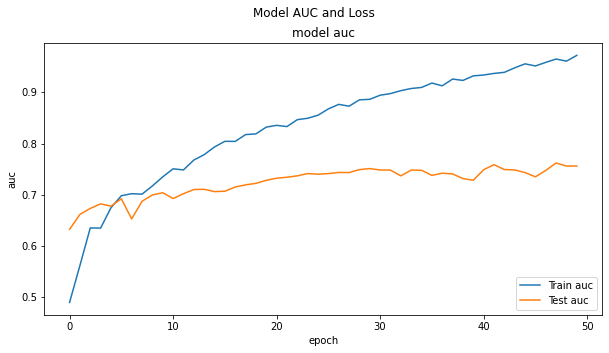

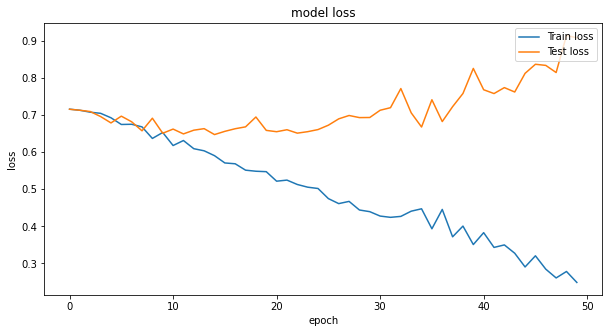

In [91]:
display_auc_loss(models[5], histories[5])

# Version 6

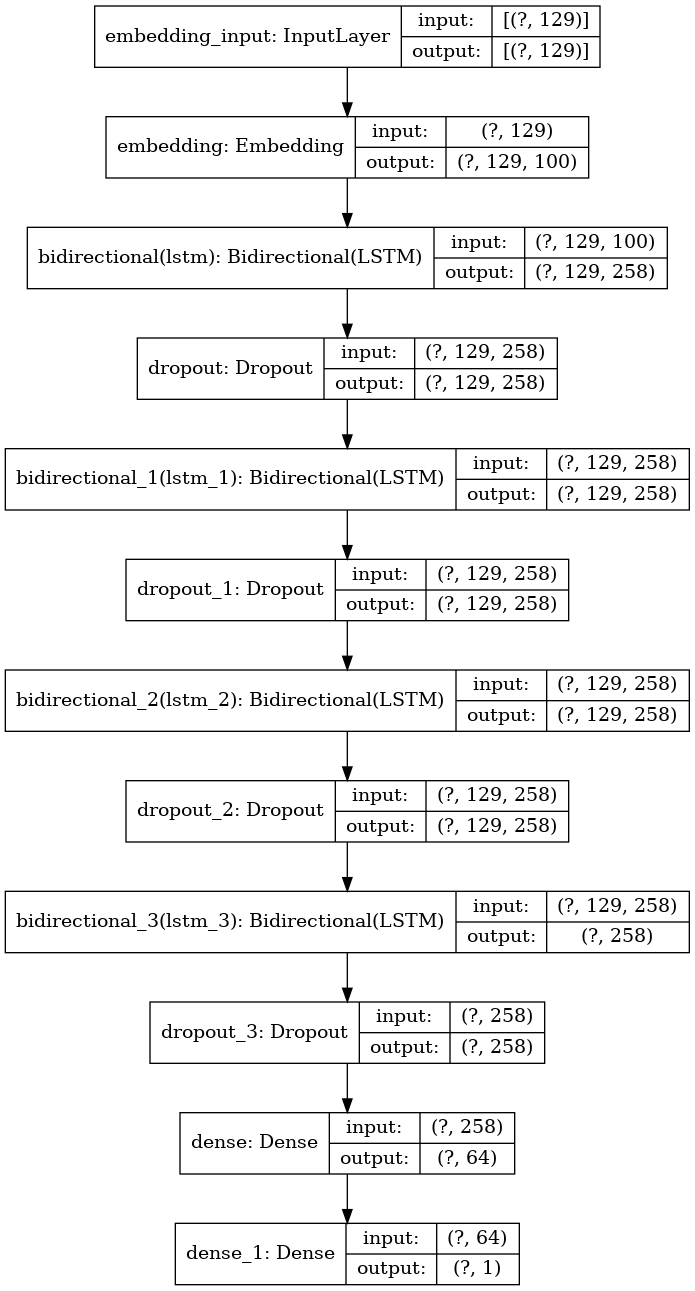

In [92]:
tf.keras.backend.clear_session()
models[6] = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(max_length)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

tf.keras.utils.plot_model(models[6], show_shapes=True)

In [93]:
%%time
# categorical_crossentropy
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
models[6].compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])
histories[6] = models[6].fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
1/1 - 4s - loss: 0.6932 - auc: 0.4992 - val_loss: 0.6973 - val_auc: 0.6066
Epoch 2/50
1/1 - 1s - loss: 0.6898 - auc: 0.5742 - val_loss: 0.6906 - val_auc: 0.6327
Epoch 3/50
1/1 - 1s - loss: 0.6849 - auc: 0.6116 - val_loss: 0.6812 - val_auc: 0.6495
Epoch 4/50
1/1 - 1s - loss: 0.6802 - auc: 0.6322 - val_loss: 0.6741 - val_auc: 0.6577
Epoch 5/50
1/1 - 1s - loss: 0.6645 - auc: 0.6848 - val_loss: 0.6562 - val_auc: 0.6647
Epoch 6/50
1/1 - 1s - loss: 0.6422 - auc: 0.7067 - val_loss: 0.6673 - val_auc: 0.6798
Epoch 7/50
1/1 - 1s - loss: 0.6322 - auc: 0.7215 - val_loss: 0.6962 - val_auc: 0.6404
Epoch 8/50
1/1 - 1s - loss: 0.6859 - auc: 0.6872 - val_loss: 0.6419 - val_auc: 0.6929
Epoch 9/50
1/1 - 1s - loss: 0.6018 - auc: 0.7402 - val_loss: 0.7345 - val_auc: 0.6991
Epoch 10/50
1/1 - 1s - loss: 0.6789 - auc: 0.7297 - val_loss: 0.6304 - val_auc: 0.7089
Epoch 11/50
1/1 - 1s - loss: 0.5885 - auc: 0.7627 - val_loss: 0.6440 - val_auc: 0.6931
Epoch 12/50
1/1 - 1s - loss: 0.6152 - auc: 0.7530 - 

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       165
           1       0.70      0.60      0.64       145

    accuracy                           0.69       310
   macro avg       0.69      0.68      0.69       310
weighted avg       0.69      0.69      0.69       310

Absolute:
[[127  38]
 [ 58  87]]
True:
[[0.76969697 0.23030303]
 [0.4        0.6       ]]
Predicted:
[[0.68648649 0.304     ]
 [0.31351351 0.696     ]]


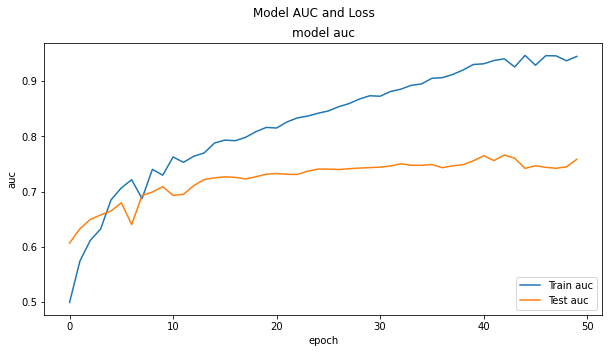

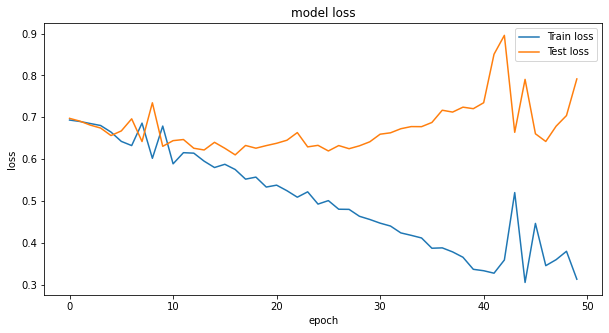

In [94]:
display_auc_loss(models[6], histories[6])

# Model Comparison Results

They are all about the same.

High number of epochs don't improve AUC:

![](.\images\long2.png)

# Saving Models

In [95]:
# pickle.dump(history.history, open('/content/drive/MyDrive/Flatiron/Module4/3-22-2021', 'wb'))
# model.save('/content/drive/MyDrive/Flatiron/Module4/3-22-2021-model')

In [96]:
# for i in models.keys():
#     pickle.dump(histories[i].history, open(f'./histories_{i}', 'wb'))
#     models[i].save(f'./models_{i}')